# 3章　確率的勾配降下法

正則化・正規化に関する議論はモデルとまとめて議論する必要があるので、最適化のみ議論。

教科書の中では、勾配降下法とその変種たちについて議論があった。

ここでは、最適化の文脈でよく使われるテスト関数を使って、最適化方法の特徴を洗い出す。

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import japanize_matplotlib

import sys
sys.path.append('../src')
import objective as obj

In [61]:
def run_optimization(optimizer, f, x, max_iter=1000):
    path = np.empty((max_iter + 1, 2))
    path[0, :] = x.detach().numpy()
    for i in range(max_iter):
        # optimization
        optimizer.zero_grad()
        y = f(x)
        y.backward()
        torch.nn.utils.clip_grad_norm_(x, 1.0)
        # 更新する。
        optimizer.step()

        path[i+1, :] = x.detach().numpy()

    return path

In [79]:
def plot_history(func_name, functions, history_dict, min_dict, initials, start=-4.0, stop=4.0, elev=45, azim=90):

    f = functions[func_name]
    history_res = history_dict[func_name]
    minimum_res = min_dict[func_name]
    # グリッドの用意
    grid = np.arange(start=start, stop=stop, step=0.1)
    grid_size = len(grid)
    x1 = torch.Tensor(grid)
    x2 = torch.Tensor(grid)

    # グリッドポイントの値を作成
    xs = torch.cartesian_prod(x1, x2)
    x1, x2 = torch.meshgrid(x1, x2)
    ys = f(xs.T).reshape(grid_size, grid_size)

    # 勾配のベクトル図を作成する。
    fig = plt.figure(figsize=(14, 6))
    fig.suptitle(f'{func_name}: optimization', fontsize=16)
    ax1 = fig.add_subplot(121)
    ax1.set_title("Contour")
    ax1.set_xticks(np.arange(start, stop, 2))
    ax1.set_yticks(np.arange(start, stop, 2))
    ax1.set_xlabel("$x$", fontsize=15)
    ax1.set_ylabel("$y$", fontsize=15)
    ax1.grid()

    for (optim_name, history) in history_res.items():
        ax1.plot(history[:, 0], history[:, 1], alpha=0.5, label=optim_name, linestyle="--")

    ax1.scatter([initials[0]],
             [initials[1]],
             label='starting point',
             color="blue")
    ax1.scatter([minimum_res[0]],
             [minimum_res[1]],
             label='global minimum',
             color="red")

    contours = ax1.contour(x1, x2, ys, levels=20)
    ax1.clabel(contours, inline=1, fontsize=10, fmt="%.2f")
    ax1.legend()

    # グラフを作成する。
    ax2 = fig.add_subplot(122, projection="3d")
    ax2.view_init(elev=elev, azim=azim)
    ax2.set_title("Surface")
    ax2.set_xlabel("$x$", fontsize=15)
    ax2.set_ylabel("$y$", fontsize=15)
    ax2.set_zlabel("$z$", fontsize=15)

    for (optim_name, history) in history_res.items():
        y_hist = f(torch.Tensor(history.T)).detach().numpy()
        ax2.plot3D(history[:, 0], history[:, 1], y_hist, alpha=0.5, label=optim_name,
                 linestyle="--")
    ax2.plot_surface(x1, x2, ys, alpha=0.2, cmap='viridis')
    ax2.legend()
    plt.tight_layout()
    plt.show()

In [99]:
# テスト関数群の準備
functions = {}
functions['Sphere'] = obj.sphere
functions['booth'] = obj.booth
functions['rosenbrock'] = obj.rosenbrock
functions['ackley'] = obj.ackley
functions['easom'] = obj.easom


# 最小値の定義
minimums={}
minimums['Sphere'] = [0, 0]
minimums['booth'] = [1, 3]
minimums['rosenbrock'] = [1, 1]
minimums['ackley']=[0, 0]
minimums['easom'] = [np.pi, np.pi]

## 検証用設定の準備
lr =0.01

initials = [-2.0, 1.0]

# 最適化アルゴリズムの定義
optimizers = {}
optimizers['SGD'] = optim.SGD
optimizers['momentum'] = optim.SGD
optimizers['AdaGrad'] = optim.Adagrad
optimizers['RMSProp'] = optim.RMSprop
optimizers['Adadelta'] = optim.Adadelta
optimizers['Adam'] = optim.Adam


In [100]:
# 最適化の実施
history_res = {}
for (func_name ,f) in functions.items():
    history_res[func_name] = {}
    for (optim_name, optim_class) in optimizers.items():
        x_init = torch.tensor(initials, requires_grad=True)
        
        if optim_name == 'SGD':
            optimizer = optim_class([x_init], lr=lr)
        elif optim_name == 'momentum':
            optimizer = optim_class([x_init], lr=lr, momentum=0.8)
        else:
            optimizer = optim_class([x_init])

        history_res[func_name][optim_name] = run_optimization(optimizer, f,
                                                       x_init)


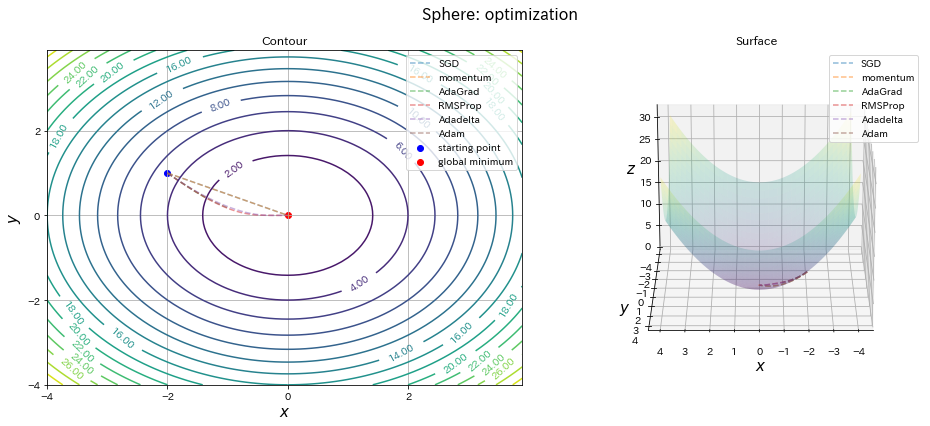

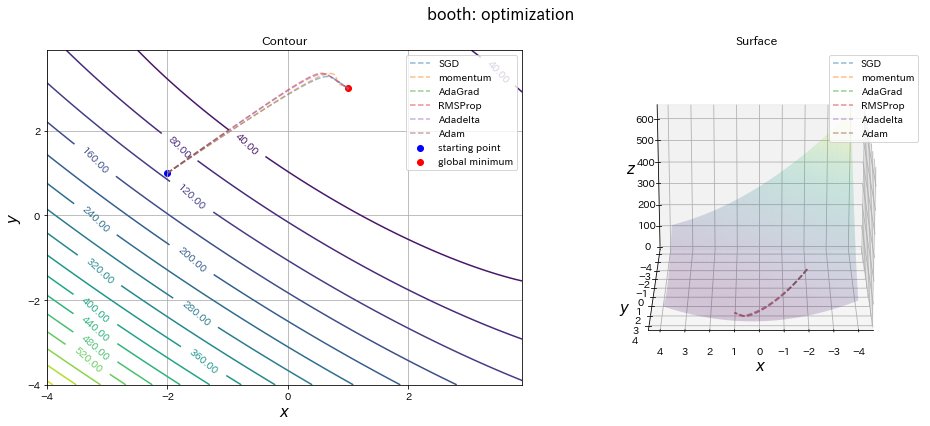

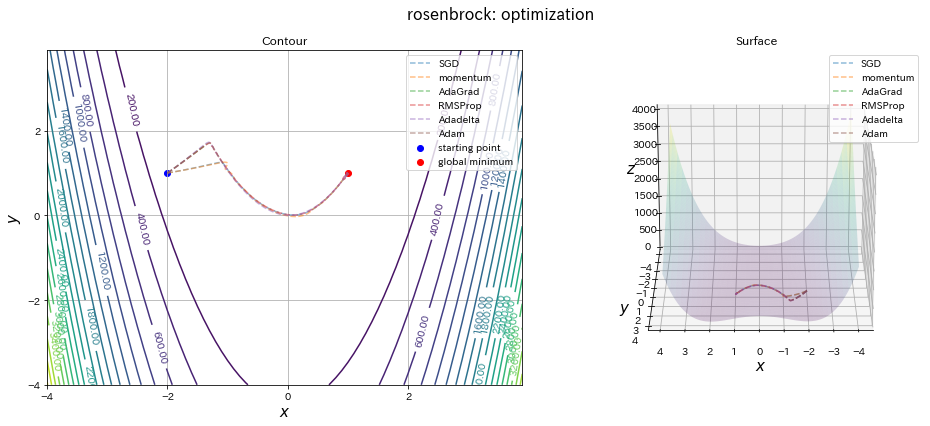

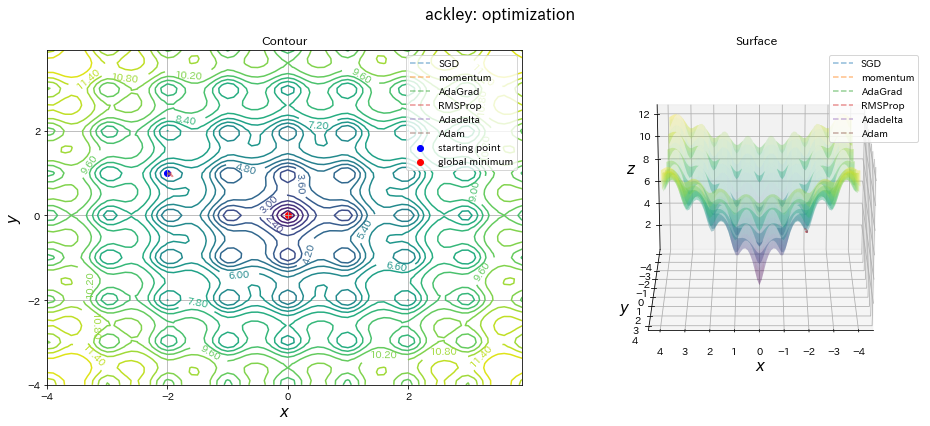

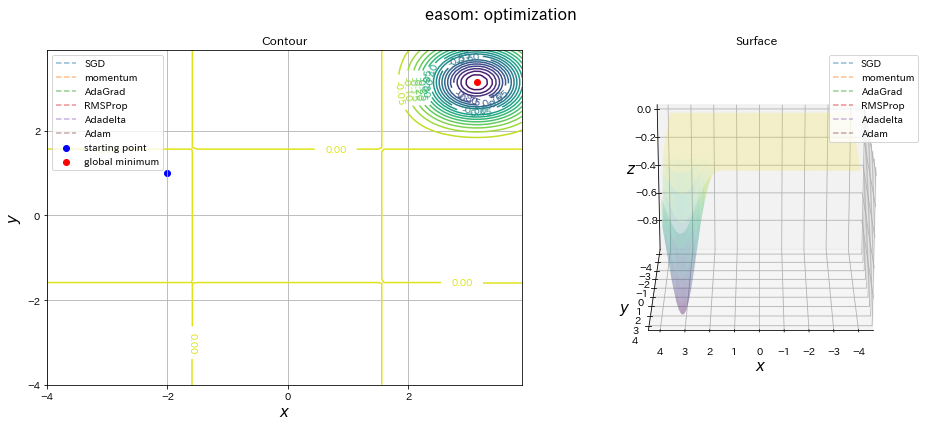

In [101]:
# plot
for func_name in functions.keys():
    plot_history(func_name, functions, history_res, minimums, initials, elev=20)

## 特徴

挙動は勾配降下法・モメンタムとその他の2つのグループに整理されるように見える。

最もシンプルなSphere関数でも大きな特徴の違いが見える。
- 勾配降下法・モメンタムはあくまでも勾配のみを考慮しているので、直線的に最適解へ近づいていく
- その他の手法は2次項以降も評価するため、直線的にすすまない。

またどのようなアルゴリズムを使っても、以下のような関数においては大域的最適解に到達するのは非常に難しいことがわかる。
- 局所最適解が数多く存在する関数
  - そもそも非凸関数を最適化するのは難しい問題。
  - 初期値をうまく設定するか、学習率を高くする必要があると思われる。
- 勾配がほとんど消失する関数
  - 勾配に基づいて最適化するため、仕方のないタイプの問題。
  - 勾配消失問題があるNNモデルにおいて学習が進まないのは、これのイメージ。


今回の実験では残念ながら、AdaGrad, RMSProp, Adadelta, Adamについては挙動の違いが実験から見えて来なかった。

適当な関数があれば教えて下さい。


最近は[SAM](https://arxiv.org/abs/2010.01412)という手法も提案されていて、こうした関数を使うと非凸関数でもうまくいく可能性はありそう。